## Importing swe-BERT for initial training

In [1]:
!pip install transformers
!pip install tqdm

import torch
import numpy as np
import math
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AutoModel
from transformers.modeling_outputs import BaseModelOutputWithPooling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# collab command to install transformers



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Kod\BorsBot\NLP-DocBERT-financial-news-trading\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
from torch.utils.data import Dataset


import re
def clean_txt (text):
  text = re.sub("¹", "", text)
  text=re.sub("(\\W)+","  ", text)
  return text


class SNLIDataset(Dataset):

    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue
                # print(line)
                if max_size and i >= max_size:
                    break
                try:
                  sentence, sentiment_value = line.rstrip().split('|') # Delimeter to be chosen
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                self.xs.append(clean_txt(sentence))
                self.ys.append(int(sentiment_value.split("\"")[0])) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(sentence.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

class SNLIDataset_shell_class(SNLIDataset):
    def __init__(self, xs, ys, sentence_lengths):
      self.xs = xs
      self.ys = ys
      self.sentence_lengths = sentence_lengths

In [3]:


def divide_dataset_to_train_and_test(SNLIDataset, shell_class, percentage_to_train):
    random_indices = torch.randperm(len(SNLIDataset.xs))
    num_of_sent_in_train = math.floor(len(SNLIDataset.xs)*(percentage_to_train))
 
    train_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[0:num_of_sent_in_train])))
    train_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[0:num_of_sent_in_train])))


    test_dataset_xs = np.array(list(map(SNLIDataset.xs.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_ys = np.array(list(map(SNLIDataset.ys.__getitem__, random_indices[num_of_sent_in_train:])))
    test_dataset_sent_lengths = np.array(list(map(SNLIDataset.sentence_lengths.__getitem__, random_indices[num_of_sent_in_train:])))
  
    train_dataset = shell_class(train_dataset_xs, train_dataset_ys, train_dataset_sent_lengths)

    test_dataset = shell_class(test_dataset_xs, test_dataset_ys, test_dataset_sent_lengths)
    

    return train_dataset, test_dataset



## New and improved financial news dataset

In [4]:
from torch.utils.data import Dataset

class FinancialNewsDataset(Dataset):
    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue

                if max_size and i >= max_size:
                    break
                try:
                  header, body, sentiment_value =  line.strip().split(",")
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                financial_news = f"{header} {body}"
                self.xs.append(financial_news)
                self.ys.append(int(sentiment_value)+1) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(financial_news.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)
    
class FinancialNewsDataset_shell_class(FinancialNewsDataset):
    def __init__(self, xs, ys, sentence_lengths):
      self.xs = xs
      self.ys = ys
      self.sentence_lengths = sentence_lengths

## Create all datasets

In [25]:
financial_news_train_dataset = SNLIDataset('./Financial Data/cleaned_financial_phrases_train.csv')
financial_news_test_dataset = SNLIDataset('./Financial Data/cleaned_financial_phrases_test.csv')
amazon_review_dataset = SNLIDataset('./amazon-review-data/cleaned_amazon_reviews.csv')
test_dataset = SNLIDataset('./sweOnlyProcData/cleaned_all_news.txt')

# data = financial_news_train_dataset[121]

amazon_review_train_dataset, amazon_review_test_dataset = divide_dataset_to_train_and_test(amazon_review_dataset, SNLIDataset_shell_class, 0.9)


print("Financial phrases train dataset length: {:,}".format(len(financial_news_train_dataset)))
print("Financial phrases test dataset length: {:,}".format(len(financial_news_test_dataset)))

print("Amazon reviews train dataset length: {:,}".format(len(amazon_review_train_dataset)))
print("Amazon reviews test dataset length: {:,}".format(len(amazon_review_test_dataset)))

print("Own collected news dataset length: {:,}".format(len(test_dataset)))



Financial phrases train dataset length: 4,551
Financial phrases test dataset length: 506
Amazon reviews train dataset length: 27,000
Amazon reviews test dataset length: 3,000
Own collected news dataset length: 521


In [5]:
print(financial_news_train_dataset.xs[:10]) # Dataseten är på något vis olika formatterad som gör att det blir fel senare när man tränar modellen
print(amazon_review_train_dataset.xs[:10])

['Finska  flygbolaget  Finnair  inleder  de  tillfälliga  uppsägningarna  av  kabinpersonal  i  februari  X  ', 'Motsvarande  ökning  av  aktiekapitalet  totalt  X  X  euro  registrerades  i  det  finska  handelsregistret  den  X  maj  X  ', 'Under  det  tredje  kvartalet  av  räkenskapsåret  X  svängde  Efore  till  en  nettoförlust  på  X  X  EUR  jämfört  med  en  nettovinst  på  X  X  EUR  för  motsvarande  period  X  ', 'ALEXANDRIA  Virginia  X  oktober  Aaron  Moss  från  Hampshire  Storbritannien  har  utvecklat  en  dekorativ  design  för  en  telefon  meddelade  US  Patent  amp  Trademark  Office  ', 'Vaisala  Oyj  Börsmeddelande  X  X  X  klo  X  X  X  X  Årsstämman  i  Vaisala  Oyj  beslutade  den  X  mars  X  att  godkänna  bolagets  årsredovisning  för  X  ', 'Produktens  framkantsvikning  maximerar  vädertålighet  och  möjliggör  en  sömlös  takfinish  ', 'Raute  är  noterat  på  den  nordiska  börsen  i  Helsingfors  ', 'KESKO  FOOD  AB  PRESSMEDDELANDE  X  X  X  KL  X  

In [5]:
real_news_dataset = FinancialNewsDataset('../newsBotv1/newsDataset/formattedNews/formattedNews.csv')
real_news_train_dataset, real_news_test_dataset = divide_dataset_to_train_and_test(real_news_dataset, FinancialNewsDataset_shell_class, 0.9)

In [6]:
real_news_train_dataset.xs[:10]

array(['festi hf presentation of q4 and 12m 2022 results festi hf published its q4 2022 and 12m 2022 condensed consolidated interim financial statements after market closing on8february 2023 please find attached the q4and 12m 2022 investor presentation which was held this morningthursday 9february 2023 at 830 attachment a hrefhttpsml',
       'cell impact kraftig omsättningsökning  analysguiden även om cell impacts utveckling går långsammare än vi tidigare prognosticerat bedömer vi att cell impacts affärsid håller och ger möjligheter för en positiv utveckling på några års sikt vi är dock fortsatt kortsiktigt avvaktande till aktien innan vi ser en mer stabil vändning i volym och försäljning och hur framtida kapitalbehov utvecklas',
       'sminn hf aalfundur smans hf verur haldinn 9 mars 2023 aalfundur smans hf verur haldinn fimmtudaginn 9 mars 2023 kl 1600 a hilton reykjavk nordica suurlandsbraut 2 reykjavk mefylgjandi er fundarbo drög a dagskr fundarins og tillögur stjrnar flagsins se

## Dataset analysis
Here we analyze the length distribution for each dataset

In [7]:
import matplotlib.pyplot as plt

def plot_data_length(sentence_lengths, datasetName, resolution=1, xparams=True):
    plot_data_length.total_plots += 1
    plt.figure(plot_data_length.total_plots)
    plt.hist(sentence_lengths, bins=int(np.max(sentence_lengths)*resolution), density=True)
    plt.xlabel(datasetName)
    if not xparams:
      plt.tick_params(bottom=False, labelbottom=False)

plot_data_length.total_plots = 0

plot sentence lengths

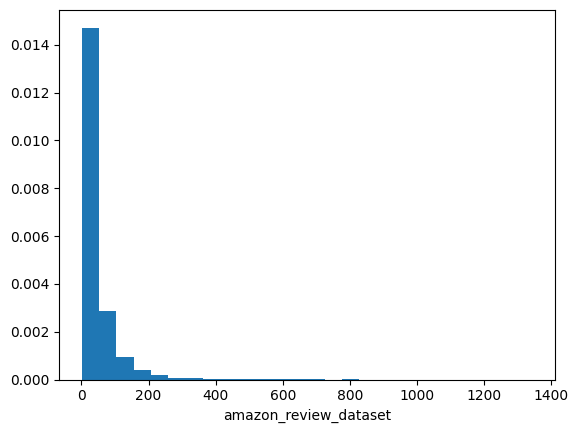

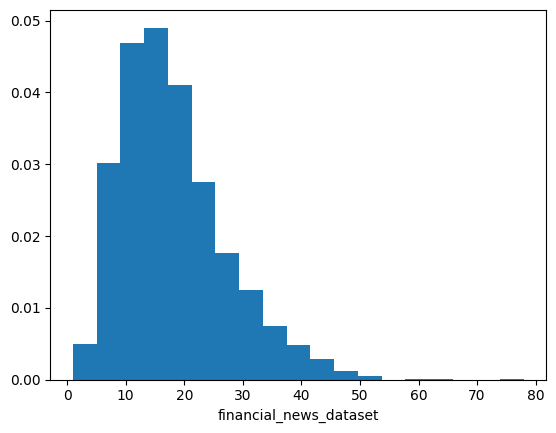

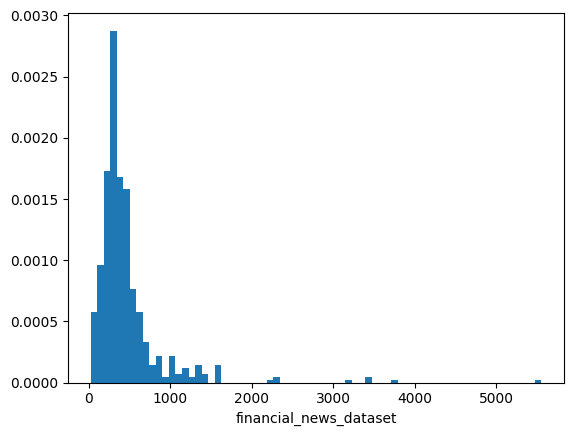

In [8]:
plot_data_length(amazon_review_dataset.sentence_lengths, "amazon_review_dataset", 1/50)
plot_data_length(np.concatenate([financial_news_test_dataset.sentence_lengths, financial_news_train_dataset.sentence_lengths]), "financial_news_dataset", 1/4)
plot_data_length(test_dataset.sentence_lengths, "financial_news_dataset", 1/80)


# Textfil på formatet data | label | datalängd

# for sentence_length in amazon_reviews.sentence_lengths: 15,17 % av denna. Använd divide_dataset_to_train_and_test
    # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

# for sentence_length in financial_phrases.sentence_lengths:  #HELA DENNA
    # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

# for sentence_length in own_collected_news.sentence_lengths: # HELA DENNA 
        # hitta rad i textfilen som har datalängd sentence length
        # annars kolla datalängd sentence_length-1 (upprepa tills ngt hittas)
    # ta bort den raden och lägg i separat textfil

plot label distribution

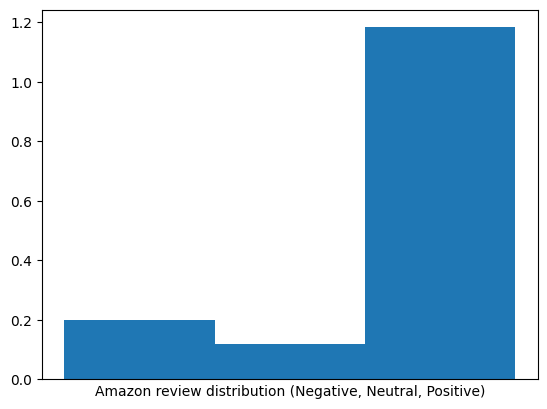

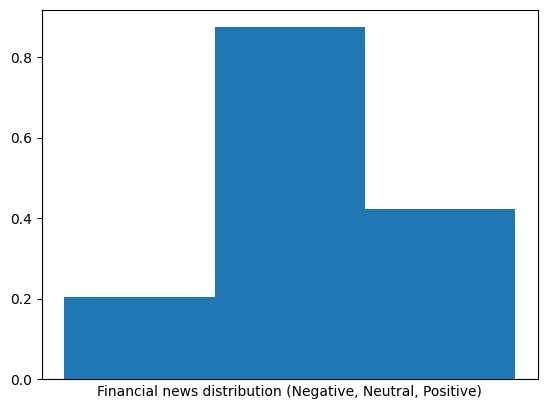

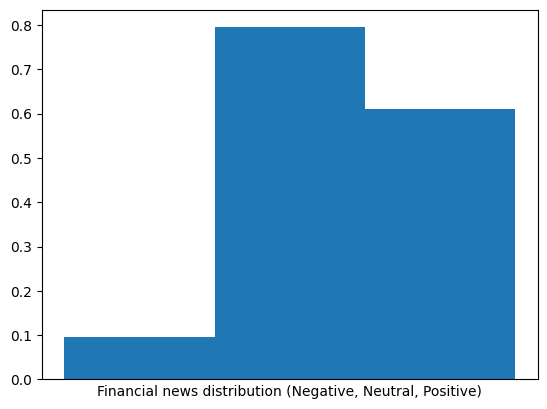

In [9]:
plot_data_length(amazon_review_dataset.ys, "Amazon review distribution (Negative, Neutral, Positive)", 1.5, xparams=False)
plot_data_length(np.concatenate([financial_news_test_dataset.ys, financial_news_train_dataset.ys]), "Financial news distribution (Negative, Neutral, Positive)", 1.5, xparams=False)
plot_data_length(test_dataset.ys, "Financial news distribution (Negative, Neutral, Positive)", 1.5, xparams=False)

## Import swedish bert

In [94]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AutoModel, RobertaTokenizer, RobertaModel
from transformers.modeling_outputs import BaseModelOutputWithPooling

tokenizer = RobertaTokenizer.from_pretrained('AI-Sweden-Models/roberta-large-1160k', do_lower_case=False)
bert = RobertaModel.from_pretrained('AI-Sweden-Models/roberta-large-1160k')

Some weights of RobertaModel were not initialized from the model checkpoint at AI-Sweden-Models/roberta-large-1160k and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tokenized = tokenizer(text=amazon_review_train_dataset[1][0], padding='longest', return_tensors='pt')
print(amazon_review_train_dataset[1][0])
print(tokenized.input_ids)
print(tokenized)

Fantastiskt  praktiskt  och  sött  
tensor([[    2, 38313,  6370,    36, 40365,     3]])
{'input_ids': tensor([[    2, 38313,  6370,    36, 40365,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


### Define colate function that tokenizes

In [9]:
def tensor_split(text1, seq_size=200, overlap=50, add_to_start = 2):
  l_total = []
  l_parcial = []
  cls_tokens = torch.unsqueeze(torch.as_tensor([add_to_start]* text1.shape[0]), dim=1)
  if text1.shape[1]//(seq_size-overlap) >0:
    n = text1.shape[1]//(seq_size-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      # l_parcial = torch.concat([cls_tokens, text1[:,:seq_size]], dim=1)
      l_parcial = text1[:,:seq_size]
      l_total.append(l_parcial.to(device))
    else:
      # l_parcial = torch.concat([cls_tokens, text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]], dim=1)
      l_parcial = text1[:,w*(seq_size-overlap):w*(seq_size-overlap) + seq_size]
      l_total.append(l_parcial.to(device))
  return l_total

In [10]:
def our_collate_fn(data):
    x = [a[0] for a in data]
    y = [a[1] for a in data]
    tokenized = tokenizer(text=x, padding='longest', return_tensors='pt')

    return tokenized['input_ids'], torch.as_tensor(y), tokenized['attention_mask']

In [49]:
from torch.utils.data import DataLoader

def create_training_examples(dataset, batch_size = 64, seq_size = 200, overlap = 50):
    batch_sort_order = np.array_split(dataset.sentence_lengths.argsort()[::-1], round(len(dataset) / batch_size))
    tokenized_train_data = DataLoader(dataset, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #

    for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        by = by.type(torch.LongTensor)
        yield tensor_split(bx, seq_size, overlap), tensor_split(ba, seq_size, overlap, add_to_start=1), by.to(device)
                




In [15]:
import torch.nn as nn

rnn = nn.LSTM(10, 20, batch_first = True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print("Input shape: {}".format([*input.shape]))
print("Output shape: {}".format([*output.shape]))
print("Last hidden state shape: {}".format([*hn.shape]))

Input shape: [3, 5, 10]
Output shape: [3, 5, 20]
Last hidden state shape: [1, 3, 20]


In [97]:
import torch.nn as nn
from sklearn import metrics


class DocBert(nn.Module):
    def __init__(self, bert, hidden_dim=20, num_labels=3):
        super().__init__()
        self.bert =  bert.to(device) # INTE BertForSequenceClassification
        for param in self.bert.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim, batch_first=True).to(device)
        # Input [Batch_size, sequence_length, input_size]
        # Output [1, batch_size, hidden_dim]
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, num_labels).to(device)
    
    def forward(self, x_seqs, a_seqs):
      output = []
      for x_seq, a_seq in zip(x_seqs, a_seqs):
        # print("x_seq, a_seq = {}, {}".format(x_seq, a_seq))
        output.append(self.bert(x_seq, a_seq)[0][:,0,:]) # Only get the embedding of the [CLS]-token [batch_size, number_of_sequences, input_size]
      # print(output)
      _ , (output, _) = self.lstm(torch.stack(output, dim=1)) # [1, batch_size, hidden_dim]
      output = self.relu(output)
      output = self.linear(torch.squeeze(output, dim=0))
      return torch.softmax(output, dim=1)
      #   bertified_seqs.append()
      # self.lstm(, )

    def predict(self, x_seq, a_seq):
      output = self.forward(x_seq, a_seq)
      # print("Output from forward: {}".format(output))
      batch_guess = torch.argmax(output, dim=1)
      return batch_guess

    def get_confusion_matrix(self, sequences, batch_size=8):
      predicted_tensor = torch.as_tensor([])
      correct_tensor = torch.as_tensor([])

      current_correct = 0
      
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq).to("cpu")
        # print("Prediction: {} \t Actual {}".format(*prediction, *by) )
        predicted_tensor = torch.concat((predicted_tensor, prediction))
        correct_tensor = torch.concat((correct_tensor, by.to("cpu")))
        # current_correct += torch.sum(prediction==by)
        # current_tried += batch_size
      confusion_matrix = metrics.confusion_matrix(correct_tensor.numpy(), predicted_tensor.numpy())
      


      return confusion_matrix

    def accuracy(self, sequences, batch_size=8):
      current_correct = 0
      
      current_tried = 0
      for x_seq, a_seq, by in create_training_examples(sequences, batch_size=batch_size):
        prediction = self.predict(x_seq, a_seq).to(device)
        # print("Prediction: {} \t Actual {}".format(*prediction, *by) )
        
        current_correct += torch.sum(prediction==by)
        current_tried += batch_size

      return current_correct / current_tried


#### Functions for training and testing a model

In [101]:
import torch.nn.functional as F
from tqdm import tqdm

def train_docbert(pretrained_bert, dataset, hidden_dim=512, num_labels=3, epochs=1, batch_size=2, lr=2e-5):#lr based on docbert article
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters(), lr=lr) 
  class_weights = torch.FloatTensor([1, 0.03, 0.2]).to(device)
  loss_fn = nn.CrossEntropyLoss(weight=class_weights)
  for epoch in tqdm(range(epochs)):
    i = 0
    tot_loss = 0
    for x_seqs, a_seqs, by in tqdm(create_training_examples(dataset, batch_size=batch_size, seq_size=200, overlap=50)):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)

      loss = loss_fn(preds, by)
      tot_loss += loss.item()
      i += 1

      loss.backward()
      optimizer.step()
    print("Average loss: {}".format(tot_loss/i))
    
  return docbert


def calc_opt_epoch_docbert(pretrained_bert, dataset, validation_dataset, hidden_dim=512, num_labels=3, max_epochs=50):
  docbert = DocBert(pretrained_bert, hidden_dim, num_labels)
  optimizer = torch.optim.Adam(docbert.parameters(), lr=2e-5) #lr based on docbert article
  last_accuracy = torch.as_tensor(0)
  for epoch in range(max_epochs):
    print("--- EPOCH {} ---".format(epoch))
    
    
    for x_seqs, a_seqs, by in create_training_examples(dataset, batch_size=8, seq_size=200, overlap=50):
      optimizer.zero_grad()
      preds = docbert.forward(x_seqs, a_seqs)
      loss = F.cross_entropy(preds, by)
      
      loss.backward()
      optimizer.step()
    accuracy = docbert.accuracy(validation_dataset, batch_size=1)
    print("current accuracy: {:.2f}".format(100*accuracy))
    # if torch.round(1000*accuracy) <= torch.round(1000*last_accuracy):
    #   return epoch-1
    last_accuracy = accuracy
  return max_epochs



In [14]:
def calc_from_conf_matrix(conf_matrix, label_names):
    col_sums = [0, 0, 0]
    row_sums = []
    tot_sum = 0
    for rindex, row in enumerate(conf_matrix):
        col_sums += row
        row_sums.append(sum(row))
    tot_sum = sum(row_sums)

    accuracy = 0
    for i in range(len(label_names)):
         
        # precision
        precision = conf_matrix[i][i] / col_sums[i]
        print("Precision for {} is {:.2f}%".format(label_names[i], 100*precision))

        # recall
        recall = conf_matrix[i][i] / row_sums[i]
        print("Recall for {} is {:.2f}%".format(label_names[i], 100*recall))

        accuracy += conf_matrix[i][i]
    
    # accuracy
    print("Total accuracy is {:.2f}%".format(100*accuracy/tot_sum))


In [50]:
docbert_amazon = train_docbert(bert, amazon_review_train_dataset, epochs=3)

NameError: name 'amazon_review_train_dataset' is not defined

In [32]:
docbert_finance = train_docbert(bert, financial_news_train_dataset, epochs=22)

KeyboardInterrupt: 

In [102]:
real_news_docbert = train_docbert(bert, real_news_train_dataset, epochs=60, lr=8e-4, batch_size=8)

149it [00:06, 21.83it/s]0:00<?, ?it/s]
  2%|▏         | 1/60 [00:06<06:42,  6.83s/it]

Average loss: 1.0438639241576995


149it [00:06, 22.20it/s]
  3%|▎         | 2/60 [00:13<06:32,  6.76s/it]

Average loss: 1.0005593599889102


149it [00:06, 21.68it/s]
  5%|▌         | 3/60 [00:20<06:28,  6.81s/it]

Average loss: 0.962699127677303


149it [00:07, 20.96it/s]
  7%|▋         | 4/60 [00:27<06:28,  6.93s/it]

Average loss: 0.9260884267371773


149it [00:06, 22.03it/s]
  8%|▊         | 5/60 [00:34<06:17,  6.87s/it]

Average loss: 0.9013002246818287


149it [00:06, 22.29it/s]
 10%|█         | 6/60 [00:40<06:07,  6.81s/it]

Average loss: 0.8873863060202375


149it [00:06, 22.24it/s]
 12%|█▏        | 7/60 [00:47<05:58,  6.77s/it]

Average loss: 0.8777761799377083


149it [00:06, 22.09it/s]
 13%|█▎        | 8/60 [00:54<05:51,  6.77s/it]

Average loss: 0.8702327161027281


149it [00:06, 22.14it/s]
 15%|█▌        | 9/60 [01:01<05:44,  6.76s/it]

Average loss: 0.8639025960192585


149it [00:06, 22.11it/s]
 17%|█▋        | 10/60 [01:07<05:37,  6.75s/it]

Average loss: 0.8584769372172003


149it [00:06, 21.74it/s]
 18%|█▊        | 11/60 [01:14<05:32,  6.78s/it]

Average loss: 0.8536257203793366


149it [00:06, 22.29it/s]
 20%|██        | 12/60 [01:21<05:24,  6.75s/it]

Average loss: 0.8492847229010306


149it [00:06, 22.28it/s]
 22%|██▏       | 13/60 [01:28<05:16,  6.73s/it]

Average loss: 0.8455783776788903


149it [00:06, 21.96it/s]
 23%|██▎       | 14/60 [01:34<05:10,  6.75s/it]

Average loss: 0.8423188416749839


149it [00:06, 21.45it/s]
 25%|██▌       | 15/60 [01:41<05:06,  6.81s/it]

Average loss: 0.8394051750234309


149it [00:06, 21.80it/s]
 27%|██▋       | 16/60 [01:48<05:00,  6.82s/it]

Average loss: 0.8360944274287896


149it [00:06, 21.78it/s]
 28%|██▊       | 17/60 [01:55<04:53,  6.83s/it]

Average loss: 0.8335353484089743


149it [00:06, 21.87it/s]
 30%|███       | 18/60 [02:02<04:46,  6.82s/it]

Average loss: 0.8290918281414364


149it [00:06, 21.82it/s]
 32%|███▏      | 19/60 [02:09<04:39,  6.82s/it]

Average loss: 0.823864614803519


149it [00:06, 21.88it/s]
 33%|███▎      | 20/60 [02:16<04:32,  6.82s/it]

Average loss: 0.8203068359586216


149it [00:06, 21.84it/s]
 35%|███▌      | 21/60 [02:22<04:26,  6.82s/it]

Average loss: 0.8267641119508935


149it [00:06, 21.87it/s]
 37%|███▋      | 22/60 [02:29<04:19,  6.82s/it]

Average loss: 0.8274902621371634


149it [00:06, 21.87it/s]
 38%|███▊      | 23/60 [02:36<04:12,  6.82s/it]

Average loss: 0.82172326913616


149it [00:06, 21.80it/s]
 40%|████      | 24/60 [02:43<04:05,  6.82s/it]

Average loss: 0.8122921530032318


149it [00:06, 21.83it/s]
 42%|████▏     | 25/60 [02:50<03:58,  6.82s/it]

Average loss: 0.8069106564425782


149it [00:06, 21.84it/s]
 43%|████▎     | 26/60 [02:56<03:52,  6.82s/it]

Average loss: 0.8042305867943987


149it [00:06, 21.73it/s]
 45%|████▌     | 27/60 [03:03<03:45,  6.84s/it]

Average loss: 0.8019811923071842


149it [00:06, 21.81it/s]
 47%|████▋     | 28/60 [03:10<03:38,  6.83s/it]

Average loss: 0.7992124237470178


149it [00:06, 21.78it/s]
 48%|████▊     | 29/60 [03:17<03:31,  6.84s/it]

Average loss: 0.7981808333588927


149it [00:06, 21.79it/s]
 50%|█████     | 30/60 [03:24<03:25,  6.84s/it]

Average loss: 0.7974274386495552


149it [00:06, 21.82it/s]
 52%|█████▏    | 31/60 [03:31<03:18,  6.84s/it]

Average loss: 0.7997992790785412


149it [00:06, 21.77it/s]
 53%|█████▎    | 32/60 [03:38<03:11,  6.84s/it]

Average loss: 0.8019830100488343


149it [00:06, 21.75it/s]
 55%|█████▌    | 33/60 [03:44<03:04,  6.84s/it]

Average loss: 0.8113700367460315


149it [00:06, 21.81it/s]
 57%|█████▋    | 34/60 [03:51<02:57,  6.84s/it]

Average loss: 0.8215800231735179


149it [00:06, 21.85it/s]
 58%|█████▊    | 35/60 [03:58<02:50,  6.83s/it]

Average loss: 0.8276099282623137


149it [00:06, 21.82it/s]
 60%|██████    | 36/60 [04:05<02:43,  6.83s/it]

Average loss: 0.8210016173004304


149it [00:06, 21.82it/s]
 62%|██████▏   | 37/60 [04:12<02:37,  6.83s/it]

Average loss: 0.8104114768489096


149it [00:06, 21.82it/s]
 63%|██████▎   | 38/60 [04:19<02:30,  6.83s/it]

Average loss: 0.8100880108423681


149it [00:06, 21.82it/s]
 65%|██████▌   | 39/60 [04:25<02:23,  6.83s/it]

Average loss: 0.8150986889064712


149it [00:06, 21.81it/s]
 67%|██████▋   | 40/60 [04:32<02:16,  6.83s/it]

Average loss: 0.827103883228046


149it [00:06, 21.83it/s]
 68%|██████▊   | 41/60 [04:39<02:09,  6.83s/it]

Average loss: 0.8245831019926391


149it [00:06, 21.81it/s]
 70%|███████   | 42/60 [04:46<02:02,  6.83s/it]

Average loss: 0.8112631552171388


149it [00:06, 21.80it/s]
 72%|███████▏  | 43/60 [04:53<01:56,  6.83s/it]

Average loss: 0.8061563596629456


149it [00:06, 21.81it/s]
 73%|███████▎  | 44/60 [04:59<01:49,  6.83s/it]

Average loss: 0.8094724052704421


149it [00:06, 21.62it/s]
 75%|███████▌  | 45/60 [05:06<01:42,  6.85s/it]

Average loss: 0.8092792046150105


149it [00:06, 21.79it/s]
 77%|███████▋  | 46/60 [05:13<01:35,  6.85s/it]

Average loss: 0.8172247585834272


149it [00:06, 21.78it/s]
 78%|███████▊  | 47/60 [05:20<01:28,  6.85s/it]

Average loss: 0.7993618285895994


149it [00:06, 21.85it/s]
 80%|████████  | 48/60 [05:27<01:22,  6.84s/it]

Average loss: 0.7922228486745949


149it [00:06, 21.94it/s]
 82%|████████▏ | 49/60 [05:34<01:15,  6.83s/it]

Average loss: 0.7854830194639679


149it [00:06, 21.98it/s]
 83%|████████▎ | 50/60 [05:40<01:08,  6.81s/it]

Average loss: 0.7782495829883038


149it [00:06, 21.82it/s]
 85%|████████▌ | 51/60 [05:47<01:01,  6.82s/it]

Average loss: 0.7772851678349028


149it [00:06, 21.84it/s]
 87%|████████▋ | 52/60 [05:54<00:54,  6.82s/it]

Average loss: 0.7719326331311425


149it [00:06, 21.86it/s]
 88%|████████▊ | 53/60 [06:01<00:47,  6.82s/it]

Average loss: 0.7700186407806089


149it [00:06, 21.77it/s]
 90%|█████████ | 54/60 [06:08<00:40,  6.83s/it]

Average loss: 0.7692703752709715


149it [00:06, 21.63it/s]
 92%|█████████▏| 55/60 [06:15<00:34,  6.85s/it]

Average loss: 0.7680585988415968


149it [00:06, 21.64it/s]
 93%|█████████▎| 56/60 [06:22<00:27,  6.86s/it]

Average loss: 0.7656200208119898


149it [00:06, 21.77it/s]
 95%|█████████▌| 57/60 [06:28<00:20,  6.85s/it]

Average loss: 0.7623572525562056


149it [00:06, 21.81it/s]
 97%|█████████▋| 58/60 [06:35<00:13,  6.85s/it]

Average loss: 0.7595763374495026


149it [00:06, 21.74it/s]
 98%|█████████▊| 59/60 [06:42<00:06,  6.85s/it]

Average loss: 0.7560932952285613


149it [00:06, 21.73it/s]
100%|██████████| 60/60 [06:49<00:00,  6.82s/it]

Average loss: 0.7549909149240327


Parameter containing:
tensor([[-0.0211, -0.0276, -0.0302,  ...,  0.0179,  0.0305,  0.0482],
        [-0.0364,  0.0330, -0.0256,  ...,  0.0530,  0.0182, -0.0217],
        [-0.0032,  0.0140, -0.0045,  ..., -0.0023,  0.0124,  0.0226],
        ...,
        [-0.0349, -0.0215,  0.0048,  ...,  0.0111,  0.0607,  0.0230],
        [-0.0133, -0.0329, -0.0024,  ...,  0.0154,  0.0165,  0.0269],
        [-0.0637, -0.0379, -0.0115,  ..., -0.0180,  0.0283,  0.0103]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0031,  0.0032,  0.0094,  ...,  0.0384, -0.0036,  0.0076],
        [-0.0030,  0.0061,  0.0087,  ..., -0.0070,  0.0944, -0.0162],
        [-0.0174,  0.0092,  0.0087,  ..., -0.0057, -0.0051, -0.0043],
        ...,
        [ 0.0080, -0.0162, -0.0318,  ...,  0.0013,  0.0116,  0.0136],
        [ 0.0130, -0.0054, -0.0002,  ...,  0.0143, -0.0334,  0.0357],
        [-0.0058,  0.0248, -0.0006,  ..., -0.0085,  0.0247, -0.0086]],
       device='cuda:0', requires_grad=True)


In [14]:
golden_epoch_count = calc_opt_epoch_docbert(bert, amazon_review_train_dataset, amazon_review_test_dataset)
print("best epoch amount: {}".format(golden_epoch_count))

--- EPOCH 0 ---
current accuracy: 87.83
--- EPOCH 1 ---
current accuracy: 88.63
--- EPOCH 2 ---
current accuracy: 88.30
--- EPOCH 3 ---
current accuracy: 89.17
--- EPOCH 4 ---
current accuracy: 88.57
--- EPOCH 5 ---
current accuracy: 88.73
--- EPOCH 6 ---
current accuracy: 87.03
--- EPOCH 7 ---
current accuracy: 87.47
--- EPOCH 8 ---


KeyboardInterrupt: ignored

In [ ]:
golden_epoch_count = calc_opt_epoch_docbert(bert, financial_news_train_dataset, financial_news_test_dataset)
print("best epoch amount: {}".format(golden_epoch_count))

--- EPOCH 0 ---
current accuracy: 74.70
--- EPOCH 1 ---
current accuracy: 83.60
--- EPOCH 2 ---
current accuracy: 84.19
--- EPOCH 3 ---
current accuracy: 84.39
--- EPOCH 4 ---
current accuracy: 84.19
--- EPOCH 5 ---
current accuracy: 84.19
--- EPOCH 6 ---
current accuracy: 84.19
--- EPOCH 7 ---
current accuracy: 84.19
--- EPOCH 8 ---
current accuracy: 82.61
--- EPOCH 9 ---
current accuracy: 83.99
--- EPOCH 10 ---
current accuracy: 84.78
--- EPOCH 11 ---
current accuracy: 83.60
--- EPOCH 12 ---
current accuracy: 83.79
--- EPOCH 13 ---
current accuracy: 82.61
--- EPOCH 14 ---
current accuracy: 83.20
--- EPOCH 15 ---
current accuracy: 83.40
--- EPOCH 16 ---
current accuracy: 83.00
--- EPOCH 17 ---
current accuracy: 83.99
--- EPOCH 18 ---
current accuracy: 83.79
--- EPOCH 19 ---
current accuracy: 81.82
--- EPOCH 20 ---
current accuracy: 83.00
--- EPOCH 21 ---
current accuracy: 79.25
--- EPOCH 22 ---
current accuracy: 84.19
--- EPOCH 23 ---
current accuracy: 82.81
--- EPOCH 24 ---
current a

# Results for financial news train dataset

The following is the results from the financial phrases.

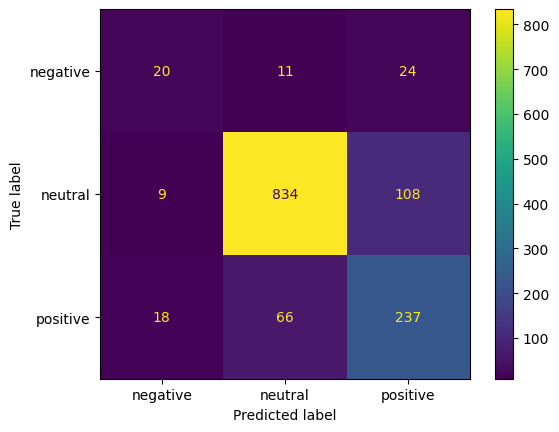

In [105]:
import matplotlib.pyplot as plt


conf_m_fin = real_news_docbert.get_confusion_matrix(real_news_dataset, batch_size=1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_m_fin, display_labels = ["negative", "neutral", "positive"])
cm_display.plot()

In [15]:
print(conf_m_fin)
calc_from_conf_matrix(conf_m_fin, ["Negative", "Neutral", "Positive"])


[[  0  21  12]
 [ 10 207  59]
 [  1 142  69]]
Precision for Negative is 0.00%
Recall for Negative is 0.00%
Precision for Neutral is 55.95%
Recall for Neutral is 75.00%
Precision for Positive is 49.29%
Recall for Positive is 32.55%
Total accuracy is 52.98%


# Results for amazon review train dataset

The following is the results from the amazon review dataset.

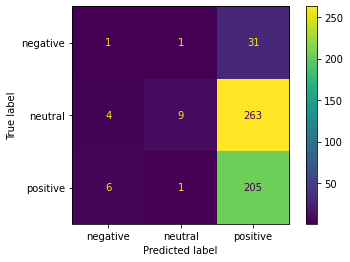

In [15]:
import matplotlib.pyplot as plt


conf_m_ama = docbert_amazon.get_confusion_matrix(test_dataset, batch_size=1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_m_ama, display_labels = ["negative", "neutral", "positive"])
cm_display.plot()

In [16]:
print(conf_m_ama)
calc_from_conf_matrix(conf_m_ama, ["Negative", "Neutral", "Positive"])


[[  1   1  31]
 [  4   9 263]
 [  6   1 205]]
Precision for Negative is 9.09%
Recall for Negative is 3.03%
Precision for Neutral is 81.82%
Recall for Neutral is 3.26%
Precision for Positive is 41.08%
Recall for Positive is 96.70%
Total accuracy is 41.27%


# Money calculations
Given that all money is invested at every purchase, this is the percentage gain after buying every stock which the model predicted as positive.

* A true positive news corresponds to a 4.9% increase in stock price.

* A true negative news corresponds to a 5.1% decrease in stock price.

* A true neutral news corresponds to a 0.1% decrease due to brokerage.

In [17]:
def calc_winnings(conf_matrix):
    return 0.949**conf_matrix[0][2] * 0.99**conf_matrix[1][2] * 1.051**conf_matrix[2][2]

In [18]:
winning_factor = calc_winnings(conf_m_fin)
# winning_factor = calc_winnings(conf_m_ama)
start_capital = 10000

print("By investing {} SEK, we would mulitply our initial investment by {:.3f}, thus having {:.0f} SEK".format(start_capital, winning_factor, start_capital*winning_factor))

By investing 10000 SEK, we would mulitply our initial investment by 9.126, thus having 91255 SEK


## Train and save the financial model

In [106]:
torch.save(real_news_docbert.state_dict(), "roberta_60e_1-0.03-0.2w_8e-4lr")

In [45]:
model = DocBert(bert, 512, 3)
model.load_state_dict(torch.load("balls"))

C:\Users\Elias\AppData\Local\Temp\ipykernel_12108\3190725866.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("balls"))


<All keys matched successfully>

## Load the financial model and evaluate it on similar test-data 
accuracy should be 88%+